<a href="https://colab.research.google.com/github/LeoTortega/Suicide_Sentiment_Analysis/blob/main/Suicide_Sentiment_Analysis_BERT_Optimized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing para detecção de mensagens suícidas

A detecção de mensagens com ideação suicida em redes sociais foi abordada usando Processamento de Linguagem Natural (NLP) e o modelo BERT. O aumento no uso das redes sociais entre jovens tem contribuído para o crescimento de problemas de saúde mental, tornando essencial a identificação precoce de mensagens suicidas. Foi implementado um modelo de classificação de textos com TFBertForSequenceClassification, utilizando regularização L2 e Dropout para evitar overfitting. O modelo foi treinado com o dataset "Detection-for-Suicide" e demonstrou boa eficácia na distinção entre mensagens suicidas e não suicidas, oferecendo uma ferramenta promissora para prevenção, desde que usada com responsabilidade.

## Preparação dos dados

Nessa etapa inicial, extraimos os dados do dataset Detection for Suicide do Hugging Face, com frases mockadas e classificadas entre suicidas e não suicidas.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Carregando dataset com as mensagens que serão utilizadas para teste e treino
df = pd.read_csv("hf://datasets/Ram07/Detection-for-Suicide/detection_final_cleaned.csv")
df.drop('cleaned_text', axis=1, inplace=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
# Verificando as cinco primeiras linhas
df.head()

,class,text
0,suicide,Ex Wife Threatening SuicideRecently I left my ...
1,non-suicide,Am I weird I don't get affected by compliments...
2,non-suicide,Finally 2020 is almost over... So I can never ...
3,suicide,i need helpjust help me im crying so hard
4,suicide,It ends tonight.I can’t do it anymore. \nI quit.


É feito a seguir uma limpeza dos nossos dados, utilizando a biblioteca nltk. Primeiramente iremos tokenizar o texto, identificar e remover as stop words e aplicar a lematização.

<ipython-input-4-494bffdb5a4a>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='coolwarm')


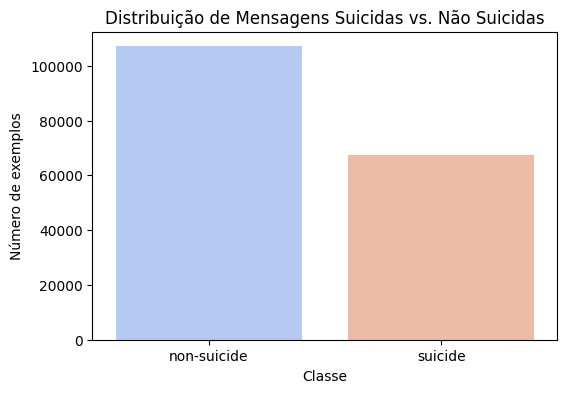

In [4]:
class_counts = df['class'].value_counts()

# Plotando o gráfico de barras com Matplotlib
plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='coolwarm')
plt.title('Distribuição de Mensagens Suicidas vs. Não Suicidas')
plt.xlabel('Classe')
plt.ylabel('Número de exemplos')
plt.show()

In [5]:
# Bibliotecas utilizadas para limpeza dos textos
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [6]:
# Tokenizer para dividir texto em palavras ou frases
nltk.download('punkt_tab')
# Identifica e limpa as Stop Words do nosso dataset
nltk.download('stopwords')
# Aplica a lematização
nltk.download('wordnet')

# Instanciando o lematizador
lemmatizer = WordNetLemmatizer()

# Carregar stop words em inglês
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
# Função para limpar o texto
def limpar_texto(texto):
  # Converter para letras minúsculas
  texto = texto.lower()

  # Remover caracteres especiais
  texto = re.sub(r'[^\w\s]', '', texto)

  # Remover números
  texto = re.sub(r'\d+', '', texto)

  # Tokenizar o texto
  tokens = word_tokenize(texto)

  # Remover Stop Words e lematizar
  tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

  # Reconstruir o texto limpo
  texto_limpo = ' '.join(tokens)

  return texto_limpo

In [8]:
df['cleaned_text'] = df['text'].apply(limpar_texto)

In [9]:
df.head()

,class,text,cleaned_text
0,suicide,Ex Wife Threatening SuicideRecently I left my ...,ex wife threatening suiciderecently left wife ...
1,non-suicide,Am I weird I don't get affected by compliments...,weird dont get affected compliment coming some...
2,non-suicide,Finally 2020 is almost over... So I can never ...,finally almost never hear bad year ever swear ...
3,suicide,i need helpjust help me im crying so hard,need helpjust help im cry hard
4,suicide,It ends tonight.I can’t do it anymore. \nI quit.,end tonighti cant anymore quit


In [10]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [11]:
# Preparar os dados
X = df['cleaned_text'].values
y = df['class'].values

In [12]:
# Usar LabelEncoder para transformar as classes em valores numéricos
le = LabelEncoder()
y = le.fit_transform(y)

Fazendo uso do método train_test_split da biblioteca sklearn, os dados serão separados em treino e teste.

In [13]:
# Dividir o dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Com a biblioteca BertTokenizer, vamos tokenizar o nosso texto para o padrão esperado pelo modelo BERT, gerando uma matriz com os seguintes items:

-	input_id: Uma lista de IDs numéricos que representam os tokens do texto de entrada. Os IDs correspondem aos tokens mapeados do vocabulário BERT
- token_type_id: Usado para casos de respostas de perguntas, onde temos que unir dois textos, sendo eles o contexto da pergunta que é representado por 0 e a pergunta em si que é representada por 1. Como nosso modelo é focado em análise de sentimentos, não utilizamos essa técnica.
- attention_mask: Uma lista de 1 e 0 que indicam quais tokens devem ser utilizados para o processamento, sendo 1 o token que será levado em consideração e 0 o ignorado.

In [14]:
# Tokenizer do BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [15]:
# Definindo método de tokenização de textos
def tokenize_texts(texts):
    return tokenizer(
        texts.tolist(),
        max_length=128,
        padding=True,
        truncation=True,
        return_tensors='tf'
    )

In [16]:
train_encodings = tokenize_texts(X_train)
test_encodings = tokenize_texts(X_test)

## Treinamento do modelo

O modelo escolhido foi o BERT por conta de sua bidirecionalidade, ou seja, ele lê o contexto de ambos os lados das palavras, fazendo com que ele possa identificar relações contextuais, além disso o modelo é pré-treinado em Masked Language Modeling, que o deixa capaz de ver relações semânticas de alta complexidade, o que é ideal para análise de sentimento. Sua vantagem em relação a outros modelos nesse cenário de classificação está justamente na sua bidirecionalidade, fazendo com que o modelo entenda palavras uma palavra no contexto completo de uma sentença, e no caso de análise de possíveis textos suicidas, o BERT consegue identificar nuances que outros modelos unidirecionais não encontrariam.

In [17]:
# Carregar o modelo BERT para classificação
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# Definir as entradas
input_ids = tf.keras.layers.Input(shape=(128), dtype='int32', name="input_ids")

In [19]:
# Camada BERT (pooler output)
bert_output = model.bert(input_ids)[1]

Para otimizar nosso modelo, foram utilizados alguns callbacks visando evitar overfitting e ter um tempo mais curto de treino. O primeiro escolhido foi a regularização L2, também conhecida como Ridge Regression que é utilizada para evitar o overfitting, ela funciona deixando o modelo mais generalista atribuindo penalidades a suas variáveis, através de uma função de custo, isso faz com que os dados tenham uma melhor predição a longo prazo não ficando preso apenas aos dados de treino.  

In [20]:
# Adicionar camada densa com regularização L2
dense = tf.keras.layers.Dense(
    128,
    activation='relu',
    kernel_regularizer=tf.keras.regularizers.l2(0.01)  # Regularização L2
)(bert_output)

Também foi utilizado o callback de Dropout, uma técnica de regularização que modifica a própria rede de neurônios eliminando aleatoriamente e temporariamente alguns neurônios, forçando-o a aprender conteúdos mais robustos por não poder confiar na presença de outros, isso reduz o overfitting e generaliza o modelo deixando-o mais próximo de seu resultado ideal.

In [21]:
# Aplicar Dropout
dropout = tf.keras.layers.Dropout(0.4)(dense)

In [22]:
# Camada de saída para classificação binária
output = tf.keras.layers.Dense(1, activation='sigmoid')(dropout)


In [23]:
# Construir o novo modelo com Dropout e L2 Regularization
model = tf.keras.models.Model(inputs=input_ids, outputs=output)

In [24]:
# Compilar o modelo
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [25]:
# # Definindo o callback de Early Stopping
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss',  # Monitora a perda de validação
#     patience=1,          # Número de épocas que podem passar sem melhora antes de parar
#     restore_best_weights=True  # Restaura os melhores pesos após a interrupção
# )

Por fim treinamos o modelo usando o método .fit(), usando como parâmetros os dados de treino e teste e definindo o número de épocas de treino e tamanho do batch.

In [26]:
history = model.fit(
    train_encodings['input_ids'],
    y_train,
    validation_data=(test_encodings['input_ids'], y_test),
    epochs=2,
    batch_size=16
    # callbacks=[early_stopping]
)

Epoch 1/2
8722/8722 [==============================] - 3933s 446ms/step - loss: 0.7350 - accuracy: 0.9656 - val_loss: 0.1458 - val_accuracy: 0.9778
Epoch 2/2
8722/8722 [==============================] - 3885s 445ms/step - loss: 0.0782 - accuracy: 0.9835 - val_loss: 0.0703 - val_accuracy: 0.9788


## Validação do modelo

Nessa etapa, com os dados gerados no histórico de treino do modelo, geramos dois gráficos, sendo um de perda e outro de acurácia, para validar a precisão do modelo e se houve overfitting.

In [27]:
# Função para plotar os gráficos de perda e acurácia
def plot_loss_accuracy(history):
    # Plotando a perda (loss)
    plt.figure(figsize=(14, 5))

    # Gráfico da perda
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Treino (loss)')
    plt.plot(history.history['val_loss'], label='Validação (loss)')
    plt.title('Perda durante o Treinamento e Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    # Gráfico da acurácia
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Treino (accuracy)')
    plt.plot(history.history['val_accuracy'], label='Validação (accuracy)')
    plt.title('Acurácia durante o Treinamento e Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()

    # Exibir os gráficos
    plt.show()

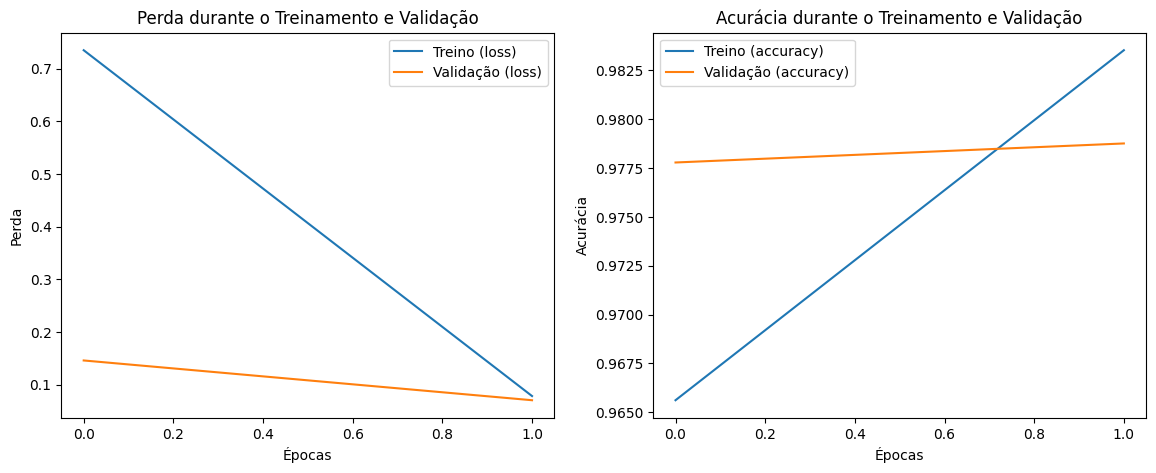

In [28]:
# Plotar os gráficos
plot_loss_accuracy(history)